In [3]:
import numpy as np
import sympy as sp
from PIL import Image, ImageTransform
from matplotlib import pyplot as plt
import time

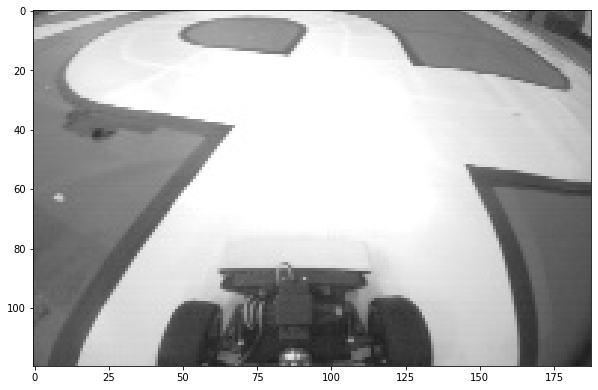

In [4]:
def img_to_np(img):
    arr = np.array(img)
    arr = np.mean(arr, -1) / 255.0
    return arr

def np_to_img(arr):
    h, w = arr.shape
    arr = (arr * 255.0).astype('uint8')
    arr = np.array([arr, arr, arr]).transpose(1, 2, 0)
    return Image.fromarray(arr, mode='RGB')

def load_img(num):
    img = Image.open('./dataset/%d.jpeg' % num)
    return img_to_np(img)

def display_img(x):
    x = x * 1.0
    x = np.array([x, x, x]).transpose((1, 2, 0))
    plt.imshow(x)
    return

def display_img_col(x):
    x = np.array(x)
    x = x.transpose(1, 2, 0)
    plt.imshow(x)
    return

plt.rcParams['figure.figsize'] = (10, 16)
display_img(load_img(1))

In [5]:
class kMeans():
    def __init__(self, k=3):
        self.k = k
        self.centroids = np.random.uniform(0, 1, self.k)
        return
    
    def update(self, arr):
        v = arr.reshape(-1, 1)
        # Find closest centroids
        cc = np.argmin((v - self.centroids.reshape(1, -1)) ** 2, axis=1)
        # Update centroids
        for i in range(0, self.k):
            mask = (cc == i).reshape(-1, 1)
            m = np.sum(mask)
            self.centroids[i] = np.sum(v * mask) / m
        return

    def get_val(self, val):
        return np.argmin((val - self.centroids) ** 2)

    def render(self, arr):
        v = arr.reshape(-1, 1)
        # Find closest centroids
        cc = np.argmin((v - self.centroids.reshape(1, -1)) ** 2, axis=1)
        # Update values
        y = np.zeros(v.shape)
        for i in range(0, self.k):
            mask = (cc == i).reshape(-1, 1)
            y += mask * self.centroids[i]
        return y.reshape(arr.shape)
    pass

def bicolor_image(img):
    km = kMeans(2)
    for i in range(4):
        km.update(img)
    img = km.render(img) == km.centroids[km.get_val(1.0)]
    return img * 1.0

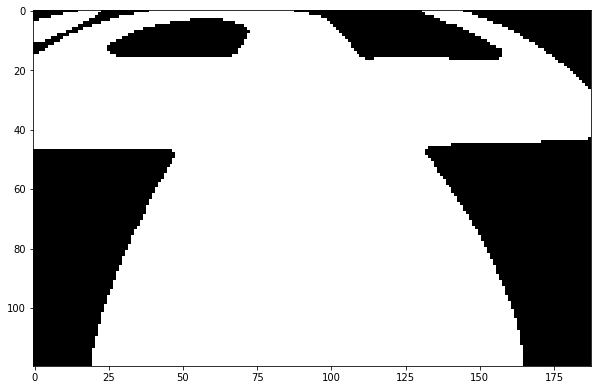

In [6]:
def pad(img, d):
    if d <= 0:
        return img
    h, w = img.shape
    nimg = np.zeros((h + d * 2, w + d * 2))
    nimg[d:-d, d:-d] = img
    nimg[0:d, :] = np.flip(nimg, axis=0)[-2*d:-d, :]
    nimg[-d:, :] = np.flip(nimg, axis=0)[d:2*d, :]
    nimg[:, 0:d] = np.flip(nimg, axis=1)[:, -2*d:-d]
    nimg[:, -d:] = np.flip(nimg, axis=1)[:, d:2*d]
    return nimg

def conv2d(img, size, kernel):
    h, w = img.shape
    img = pad(img, size // 2)
    res = np.zeros((h, w))
    for i in range(0, h):
        for j in range(0, w):
            res[i, j] = float(kernel(img[i:i+size, j:j+size]))
    return res

def flood_fill(img, x, y, col):
    def f(img, h, w, x, y, col1, col2):
        if x < 0 or x >= h or y < 0 or y >= w or img[x, y] != col1:
            return
        img[x, y] = col2
        f(img, h, w, x, y - 1, col1, col2)
        f(img, h, w, x, y + 1, col1, col2)
        f(img, h, w, x - 1, y, col1, col2)
        f(img, h, w, x + 1, y, col1, col2)
        return
    h, w = img.shape
    if img[x, y] == col:
        return
    f(img, h, w, x, y, img[x, y], col)
    return

def work_img(img):
    # Turn image into black & white
    img = bicolor_image(img)
    # Remove artifacts
    img = conv2d(img, 3, lambda x: 1.0 if np.mean(x) > 0.39 else 0.0)
    # Remove car from scene
    for i in range(90, 120, 5):
        for j in range(75, 101, 5):
            flood_fill(img, i, j, 1.0)
    # Remove artifacts
    img = conv2d(img, 3, lambda x: 1.0 if np.mean(x) > 0.37 else 0.0)
    return img


img = load_img(191)
i2 = work_img(img)
display_img(i2)

In [7]:
def solve_coeff(pin, pout):
    X0, Y0, X1, Y1, X2, Y2, X3, Y3 = pin
    x0, y0, x1, y1, x2, y2, x3, y3 = pout
    a = sp.Matrix([
        [x0, y0, 1, 0, 0, 0, -X0*x0, -X0*y0],
        [0, 0, 0, x0, y0, 1, -Y0*x0, -Y0*y0],
        [x1, y1, 1, 0, 0, 0, -X1*x1, -X1*y1],
        [0, 0, 0, x1, y1, 1, -Y1*x1, -Y1*y1],
        [x2, y2, 1, 0, 0, 0, -X2*x2, -X2*y2],
        [0, 0, 0, x2, y2, 1, -Y2*x2, -Y2*y2],
        [x3, y3, 1, 0, 0, 0, -X3*x3, -X3*y3],
        [0, 0, 0, x3, y3, 1, -Y3*x3, -Y3*y3],
    ])
    b = sp.Matrix([
        [X0], [Y0], [X1], [Y1], [X2], [Y2], [X3], [Y3], 
    ])
    alpha = sp.symarray('a', (8, 1))
    res = sp.solve(a * alpha - b)
    res = dict((str(i), float(res[i])) for i in res)
    r = list(range(8))
    for i in range(0, 8):
        r[i] = res['a_%d_0' % i]
    return r

def skew_img(img, bdcor=True, bicolor=True):
    # bdcor = True if barrel distortion corrected else False
    h, w = img.shape
    ni = np.zeros((h, w * 2))
    ni[:, w//2:w+w//2] = img[:, :]
    nh, nw = ni.shape
    im = np_to_img(img)
    # Transform from (...) to (...)
    terminal_size = ((-w*1.3/4, 0, w*1.55/4, h*4/4, w*2.55/4, h*4/4, w*5.70/4, 0) if not bdcor else
                    (-w*0.8/4, -h*0.9/4, w*1.6/4, h*4/4, w*2.4/4, h*4/4, w*4.8/4, -h*0.9/4))
    a0, a1, a2, a3, a4, a5, a6, a7 = solve_coeff(
        (0, 0, 0, h, w, h, w, 0), terminal_size)
    # xout = a0 x + a1 y + a2 / a6 x + a7 y + 1
    # yout = a3 x + a4 y + a5 / a6 x + a7 y + 1
    im = im.transform((w, h), Image.PERSPECTIVE,
                      [a0, a1, a2, a3, a4, a5, a6, a7],
                      Image.BILINEAR)
    # Switch back to numpy
    arr = img_to_np(im)
    # Remove artifacts
    if bicolor:
        arr = (arr > 0.8) * 1.0
        arr = conv2d(arr, 7, lambda x: 1.0 if np.mean(x) > 0.39 else 0.0)
    return arr

def undistort_img(img):
    h, w = img.shape
    nh, nw = int(h * 1.2), int(w * 1.2)
    k1 = -0.0000093
    k2 = -0.0000213
    nimg = np.zeros((nh, nw))
    get_pixel = lambda j, i: 0.0 if (i < 0 or i >= h or j < 0 or j >= w) else img[int(i), int(j)]
    for i in range(0, nh):
        for j in range(0, nw):
            x = j - nw / 2
            y = i - nh / 2
            x1 = x * (1 + k1 * x * x + k2 * y * y)
            y1 = y * (1 + k1 * x * x + k2 * y * y)
            # Close to center
            if abs(x1) < 1.2 or abs(y1) < 1.2:
                nimg[i, j] = get_pixel(x1 + w / 2, y1 + h / 2)
                continue
            x1, y1 = x1 + w / 2, y1 + h / 2
            # Using bilinear interpolation
            xl, xr = np.floor(x1), np.ceil(x1)
            yl, yr = np.floor(y1), np.ceil(y1)
            nimg[i, j] = (get_pixel(xl, yl) * (xr - x1) * (yr - y1) +
                          get_pixel(xr, yl) * (x1 - xl) * (yr - y1) +
                          get_pixel(xl, yr) * (xr - x1) * (y1 - yl) +
                          get_pixel(xr, yr) * (x1 - xl) * (y1 - yl))
    return nimg

In [8]:
def find_edge(arr):
    # Copy and add borders
    narr = arr * 1.0
#     narr[0, :] = 0
#     narr[:, 0] = 0
#     narr[:, -1] = 0
    h, w = narr.shape
    # Create visualization
    vis = np.array([narr, narr, narr])
    # Create initial queue
    frm = np.ones((h, w, 3)) * -1.0
    que = []
    white = lambda x, y: narr[x, y] > 0.5
    black = lambda x, y: narr[x, y] <= 0.5
    for i in range(0, h):
        for j in range(0, w):
            if white(i, j):
                continue
            flag = False
            if i >= 1 and white(i - 1, j):
                flag = True
            if i + 1 < h and white(i + 1, j):
                flag = True
            if j >= 1 and white(i, j - 1):
                flag = True
            if j + 1 < w and white(i, j + 1):
                flag = True
            if not flag:
                continue
            # Mark
            frm[i, j, :] = [i, j, 0]
            que.append((i, j))
    # Save result here
    result = np.zeros(narr.shape)
    # Breadth first search
    cnt = 0
    while len(que) > 0:
        cnt += 1
        nque = []
        for i, j in que:
            for di, dj in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                ni, nj = i + di, j + dj
                if ni < 0 or ni >= h or nj < 0 or nj >= w:
                    continue
                # Really black block
                if black(ni, nj) and frm[ni, nj, 2] < 0:
                    continue
                # A Really white block
                if white(ni, nj):
                    narr[ni, nj] = 0.0
                    frm[ni, nj, :] = frm[i, j, :]
                    nque.append((ni, nj))
                    continue
                # A not so black block
                d1 = (([ni, nj] - frm[ni, nj, :-1]) ** 2).sum()
                d2 = (([ni, nj] - frm[i, j, :-1]) ** 2).sum()
                d3 = ((frm[ni, nj, :-1] - frm[i, j, :-1]) ** 2).sum()
                if d3 > max(d1, d2) * 1.75 and d3 > 75.0:
                    result[ni, nj] = 1
                    continue
                if d2 >= d1 or frm[ni, nj, 2] >= cnt:
                    continue
                frm[ni, nj, :] = frm[i, j, :]
                frm[ni, nj, 2] = cnt
                nque.append((ni, nj))
        que = nque
    # Eliminate defects
    result = conv2d(result, 5, lambda x: 1 if x.mean() > 0.21 else 0)
    # Done
    return result

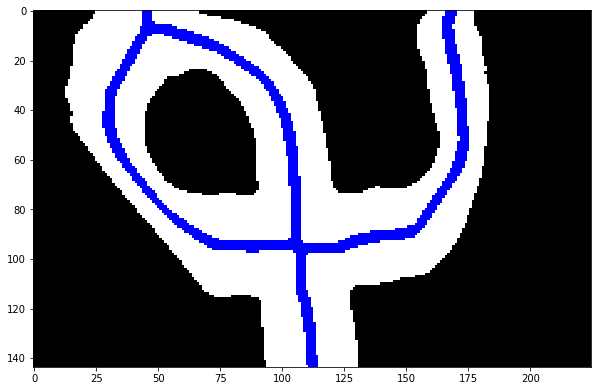

In [11]:
def process_img_final(img, bdcor=True):
    img = work_img(img)
    if bdcor:
        img = undistort_img(img)
        img = skew_img(img, bdcor=True)
    else:
        img = skew_img(img, bdcor=False)
    route = find_edge(img)
    cover = img - route
    vis = np.array([img * cover, img * cover, img])
    return vis

display_img_col(process_img_final(load_img(210)))